In [11]:
import ring
import numpy as np
import imt
import matplotlib.pyplot as plt
import tree
from imt.utils.view import view, VisOptions

In [2]:
path_pkl = "data/data_lower_extremities_human.pickle"
data = ring.utils.pickle_load(path_pkl)
Ts = 0.01
graph = [-1, 0, 0, 2, 3, 0, 5, 6]
body_names = ["hip", "sternum", "r_thigh", "r_shank", "r_foot", "l_thigh", "l_shank", "l_foot"]
imu_to_body_convention = ['10B40AFE','10B40B14', "10B40AF8", "10B40AF4", "10B40AFA", "10B40AF9", "10B40B15", "10B40AF7"]

In [3]:
imu_data = {
    body_names[i]: dict(acc=data[imu][["Acc_X", "Acc_Y", "Acc_Z"]], gyr=data[imu][["Gyr_X", "Gyr_Y", "Gyr_Z"]], mag=data[imu][["Mag_X", "Mag_Y", "Mag_Z"]])
    for i, imu in enumerate(imu_to_body_convention)
}
imu_data = tree.map_structure(lambda df: df.to_numpy(), imu_data)

ioe = imt.methods.VQF(offline=True)
dof1 = imt.wrappers.JointTracker1D(imt.wrappers.JointPosition(ioe, dof_is_1d=True))
dof2 = imt.wrappers.JointTracker1D(imt.wrappers.JointPosition(ioe))
solver = imt.Solver(graph, [imt.wrappers.DeadReckoning(ioe, zvu=True), dof1] + [dof2, dof1, dof1]*2, 0.01, body_names)

In [4]:
solver.print_graph()

-1 (Earth)
|
hip
├── sternum
├── r_thigh
│   └── r_shank
│       └── r_foot
└── l_thigh
    └── l_shank
        └── l_foot


In [5]:
qhat, extras = solver.step(imu_data)

The `DeadReckoning` wrapper internally uses whether or not motion or a rest phase is detected.

Text(0, 0.5, '1: Rest 0: Motion')

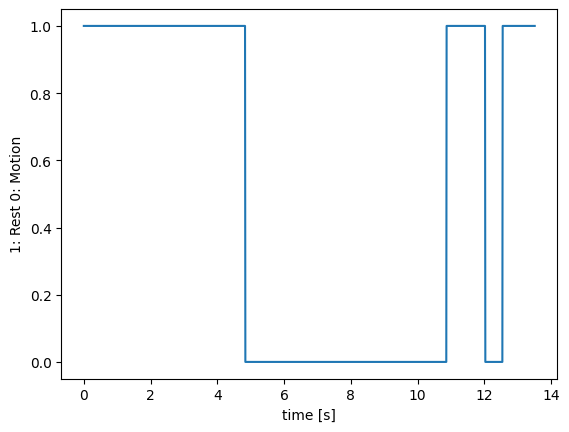

In [6]:
ts = np.arange(extras["hip"]["restDetected"].shape[0])*0.01
plt.plot(ts, extras["hip"]["restDetected"])
plt.xlabel("time [s]")
plt.ylabel("1: Rest 0: Motion")

It also estimates the position relative to the earth (-1) frame.

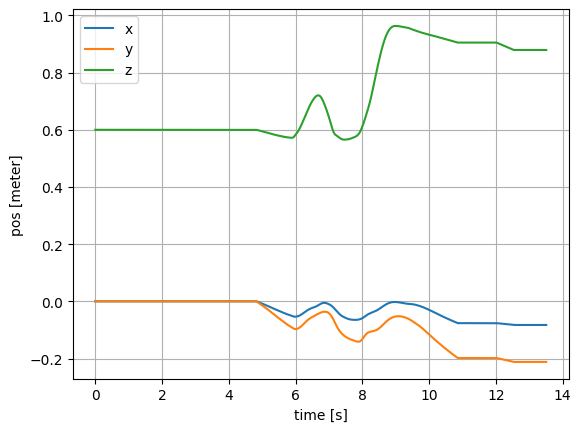

In [7]:
pos = extras["hip"]["dead-reckoning-position"] + np.array([0, 0, 0.6])
plt.plot(ts, pos, label=["x", "y", "z"])
plt.xlabel("time [s]")
plt.ylabel("pos [meter]")
plt.legend()
plt.grid()

The `JointPosition` wrapper has estimated the imu-to-joint-center vectors.

In [8]:
# position vector from joint-center-to-parent-imu (so here `hip`)
# the joint center is for the joint of `r_thigh` and the parent (so again `hip`)
# this vector is in coordinates of the hip imu
print(extras["r_thigh"]["joint-center-to-body1"])

# position vector from joint-center (joint `r_thigh` and `hip`) to the `r_thigh` imu 
# in coordinates of the `r_thigh` imu
print(extras["r_thigh"]["joint-center-to-body2"])


[-0.01998684  0.14939808  0.05991131]
[-0.12583944 -0.04439903  0.08256548]


The `JointTracker1D` tracks the joint angle by assuming that there is only a single DOF joint between two bodies.

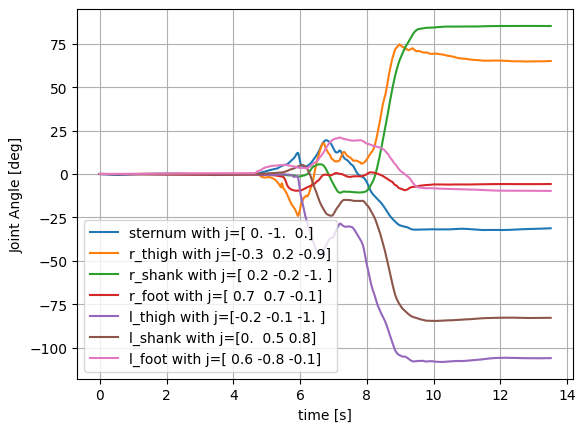

In [9]:
for body in body_names[1:]:
    plt.plot(ts, np.rad2deg(extras[body]["joint_angle_rad"]), label=f"{body} with j={np.round(extras[body]['joint_axis_direction'], 1)}")
    
plt.xlabel("time [s]")
plt.ylabel("Joint Angle [deg]")
plt.legend()
plt.grid()

## Visualisations

To save the video permanently, provide the path to where the .mp4 is  saved by specifying `offscreen_mode_options=dict(output_path=...)`



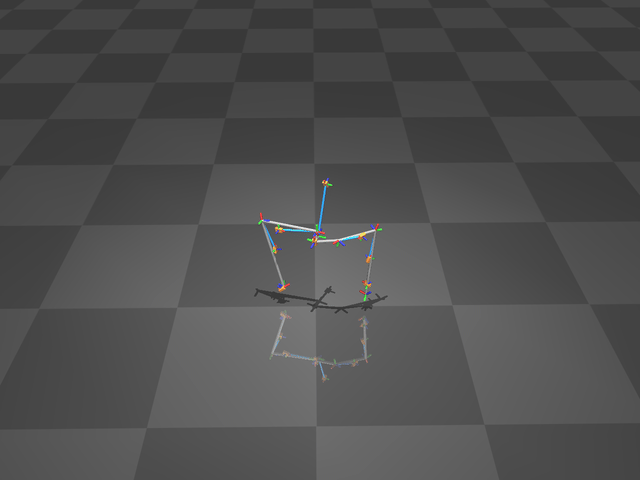

In [12]:
view(graph, qhat, extras, 100, global_translation=pos, show_every_nth_frame=10, height=480, width=640, vis_options=VisOptions(show_floor=True),
               body_names=body_names, mode="offscreen", offscreen_mode_options=dict(camid=2, github=True))

Also open the interactive viewer.

In [13]:
view(graph, qhat, extras, 100, global_translation=pos, show_every_nth_frame=4, body_names=body_names, vis_options=VisOptions(show_floor=True))

2025-02-03 16:49:39.027 python[48204:1071437] +[IMKClient subclass]: chose IMKClient_Modern
2025-02-03 16:49:39.027 python[48204:1071437] +[IMKInputSession subclass]: chose IMKInputSession_Modern
